In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

In [5]:
from lrann.datasets import DataLoader, random_train_test_split
from lrann.estimators import ImplicitEst, ExplicitEst
from lrann.models import BilinearNet
from lrann.utils import is_cuda_available
from lrann.evaluations import mrr_score, precision_recall_score, auc_score

## Config

In [6]:
config = yaml.load(open('experiment_config.yml', 'r'))

/anaconda3/envs/lrann/lib/python3.6/site-packages/ipykernel_launcher.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """Entry point for launching an IPython kernel.


In [7]:
config

{'train_test_split_seed': 42,
 'torch_init_seed': 42,
 'estimator_init_seed': 42,
 'test_percentage': 0.2,
 'embedding_dim': 32,
 'auc_selection_seed': 42,
 'mf_grid_search': {'torch_init_seed': [42, 147, 17, 28, 83],
  'l2': [0.0, 0.003, 0.01, 0.03],
  'learning_rate': [0.001, 0.003, 0.01, 0.03],
  'n_epochs': 20,
  'eval_prec_k': [1, 5, 10]},
 'mf_best_params': {'torch_init_seed': 147,
  'l2': 0.0,
  'learning_rate': 0.003,
  'n_epochs': 15,
  'mrr': 0.043602,
  'prec_at_10': 0.070638},
 'dnn_exp_params': {'mode': ['unpretrained_trainable',
   'pretrained_untrainable',
   'pretrained_trainable'],
  'model': ['perceptron',
   'single_model_elu',
   'single_model_relu',
   'single_model_sigmoid',
   'single_model_tanh',
   'double_model_elu',
   'double_model_relu',
   'double_model_sigmoid',
   'double_model_tanh',
   'triple_model_elu',
   'triple_model_relu',
   'triple_model_sigmoid',
   'triple_model_tanh'],
  'torch_init_seed': [42, 147, 17, 28, 83],
  'learning_rate': [0.001, 0.

## Data

In [8]:
data = DataLoader().load_movielens('100k')
data.implicit_(use_user_mean=True)
# data.binarize_(use_user_mean=True)

In [9]:
pd.Series(data.ratings).value_counts(normalize=False)[1.0]

54732

In [10]:
train_data, test_data = random_train_test_split(data, test_percentage=config['test_percentage'],
                                                random_state=np.random.RandomState(seed=config['train_test_split_seed']))

In [11]:
train_data

<Interactions dataset (610 users x 9724 items x 43785 interactions)>

In [12]:
test_data

<Interactions dataset (610 users x 9724 items x 10947 interactions)>

## Model

In [15]:
mf_model = BilinearNet(data.n_users, data.n_items,
                       embedding_dim=config['embedding_dim'],
                       torch_seed=config['torch_init_seed'])

In [16]:
mf_est = ImplicitEst(model=mf_model, 
                     n_iter=20, 
                     use_cuda=is_cuda_available(),
                     random_state=np.random.RandomState(seed=config['estimator_init_seed']))

In [17]:
mf_est.fit(train_data, verbose=True)

Epoch 0: loss 0.31053173394314404
Epoch 1: loss 0.13538150306867094
Epoch 2: loss 0.10195035278340991
Epoch 3: loss 0.08265660395275573
Epoch 4: loss 0.06804597029685105
Epoch 5: loss 0.06249519960096774
Epoch 6: loss 0.05501407767719326
Epoch 7: loss 0.0519090598617455
Epoch 8: loss 0.048083689600193116
Epoch 9: loss 0.04489242478814139
Epoch 10: loss 0.04405123185442419
Epoch 11: loss 0.04225196884456294
Epoch 12: loss 0.04092752458609141
Epoch 13: loss 0.04123455261996249
Epoch 14: loss 0.03921820450052836
Epoch 15: loss 0.038632396774219875
Epoch 16: loss 0.03634944172700291
Epoch 17: loss 0.03736203302187888
Epoch 18: loss 0.037059566993049124
Epoch 19: loss 0.03548089163269272


## Hyperparameter Optimization

Optimizing the MF hyperparameters to obtain a competitive baseline to beat by NN

5 random seeds x 4 regularizations x 3 learning rates x 20 epochs = 1200 steps and evaluations

In [18]:
grid_hyperparams = config['mf_grid_search']

In [19]:
grid_hyperparams

{'torch_init_seed': [42, 147, 17, 28, 83],
 'l2': [0.0, 0.003, 0.01, 0.03],
 'learning_rate': [0.001, 0.003, 0.01, 0.03],
 'n_epochs': 20,
 'eval_prec_k': [1, 5, 10]}

In [20]:
# Computation spread across multiple notebooks separating by `torch_init_seed`
results = []
counter = 0

for torch_init_seed in grid_hyperparams['torch_init_seed']:
    for learning_rate in grid_hyperparams['learning_rate']:
        for l2 in grid_hyperparams['l2']:
            
            mf_model = BilinearNet(data.n_users, data.n_items,
                                   embedding_dim=config['embedding_dim'],
                                   torch_seed=torch_init_seed)
            
            mf_est = ImplicitEst(model=mf_model, 
                                 n_iter=1, 
                                 use_cuda=is_cuda_available(),
                                 random_state=np.random.RandomState(seed=config['estimator_init_seed']),
                                 l2=l2,
                                 learning_rate=learning_rate)
            
            for epoch in range(grid_hyperparams['n_epochs']):
                
                start = time.time()
                
                mf_est.fit(train_data, verbose=False)
                
                # Evaluation
                mrr = mrr_score(mf_est, test_data).mean()
                prec_at_1 = precision_recall_score(mf_est, test_data, k=1)[0].mean()
                prec_at_5 = precision_recall_score(mf_est, test_data, k=5)[0].mean()
                prec_at_10 = precision_recall_score(mf_est, test_data, k=10)[0].mean()
                
                res = (torch_init_seed,
                       learning_rate,
                       l2,
                       epoch,
                       mrr,
                       prec_at_1,
                       prec_at_5,
                       prec_at_10)
                
                results.append(res)
                
                duration = int(time.time() - start)
                counter += 1
                
                print("Experiment {:04d}/240 took {} seconds".format(counter, duration))

Experiment 0001/240 took 4 seconds
Experiment 0002/240 took 4 seconds
Experiment 0003/240 took 4 seconds
Experiment 0004/240 took 4 seconds
Experiment 0005/240 took 4 seconds
Experiment 0006/240 took 4 seconds
Experiment 0007/240 took 5 seconds
Experiment 0008/240 took 4 seconds
Experiment 0009/240 took 5 seconds
Experiment 0010/240 took 5 seconds
Experiment 0011/240 took 5 seconds
Experiment 0012/240 took 4 seconds
Experiment 0013/240 took 4 seconds
Experiment 0014/240 took 4 seconds
Experiment 0015/240 took 4 seconds
Experiment 0016/240 took 4 seconds
Experiment 0017/240 took 4 seconds
Experiment 0018/240 took 4 seconds
Experiment 0019/240 took 4 seconds
Experiment 0020/240 took 4 seconds
Experiment 0021/240 took 4 seconds
Experiment 0022/240 took 4 seconds
Experiment 0023/240 took 7 seconds
Experiment 0024/240 took 5 seconds
Experiment 0025/240 took 5 seconds
Experiment 0026/240 took 5 seconds
Experiment 0027/240 took 5 seconds
Experiment 0028/240 took 4 seconds
Experiment 0029/240 

Experiment 0236/240 took 4 seconds
Experiment 0237/240 took 4 seconds
Experiment 0238/240 took 4 seconds
Experiment 0239/240 took 4 seconds
Experiment 0240/240 took 4 seconds
Experiment 0241/240 took 4 seconds
Experiment 0242/240 took 4 seconds
Experiment 0243/240 took 4 seconds
Experiment 0244/240 took 5 seconds
Experiment 0245/240 took 5 seconds
Experiment 0246/240 took 5 seconds
Experiment 0247/240 took 5 seconds
Experiment 0248/240 took 5 seconds
Experiment 0249/240 took 6 seconds
Experiment 0250/240 took 6 seconds
Experiment 0251/240 took 6 seconds
Experiment 0252/240 took 6 seconds
Experiment 0253/240 took 6 seconds
Experiment 0254/240 took 6 seconds
Experiment 0255/240 took 7 seconds
Experiment 0256/240 took 7 seconds
Experiment 0257/240 took 7 seconds
Experiment 0258/240 took 7 seconds
Experiment 0259/240 took 7 seconds
Experiment 0260/240 took 7 seconds
Experiment 0261/240 took 4 seconds
Experiment 0262/240 took 4 seconds
Experiment 0263/240 took 5 seconds
Experiment 0264/240 

Experiment 0470/240 took 4 seconds
Experiment 0471/240 took 4 seconds
Experiment 0472/240 took 4 seconds
Experiment 0473/240 took 4 seconds
Experiment 0474/240 took 4 seconds
Experiment 0475/240 took 4 seconds
Experiment 0476/240 took 4 seconds
Experiment 0477/240 took 4 seconds
Experiment 0478/240 took 4 seconds
Experiment 0479/240 took 4 seconds
Experiment 0480/240 took 4 seconds
Experiment 0481/240 took 4 seconds
Experiment 0482/240 took 4 seconds
Experiment 0483/240 took 4 seconds
Experiment 0484/240 took 4 seconds
Experiment 0485/240 took 4 seconds
Experiment 0486/240 took 4 seconds
Experiment 0487/240 took 4 seconds
Experiment 0488/240 took 4 seconds
Experiment 0489/240 took 4 seconds
Experiment 0490/240 took 4 seconds
Experiment 0491/240 took 4 seconds
Experiment 0492/240 took 4 seconds
Experiment 0493/240 took 4 seconds
Experiment 0494/240 took 4 seconds
Experiment 0495/240 took 4 seconds
Experiment 0496/240 took 4 seconds
Experiment 0497/240 took 5 seconds
Experiment 0498/240 

Experiment 0705/240 took 5 seconds
Experiment 0706/240 took 6 seconds
Experiment 0707/240 took 5 seconds
Experiment 0708/240 took 5 seconds
Experiment 0709/240 took 5 seconds
Experiment 0710/240 took 5 seconds
Experiment 0711/240 took 5 seconds
Experiment 0712/240 took 5 seconds
Experiment 0713/240 took 5 seconds
Experiment 0714/240 took 5 seconds
Experiment 0715/240 took 5 seconds
Experiment 0716/240 took 5 seconds
Experiment 0717/240 took 5 seconds
Experiment 0718/240 took 5 seconds
Experiment 0719/240 took 5 seconds
Experiment 0720/240 took 5 seconds
Experiment 0721/240 took 5 seconds
Experiment 0722/240 took 5 seconds
Experiment 0723/240 took 5 seconds
Experiment 0724/240 took 5 seconds
Experiment 0725/240 took 5 seconds
Experiment 0726/240 took 4 seconds
Experiment 0727/240 took 5 seconds
Experiment 0728/240 took 5 seconds
Experiment 0729/240 took 4 seconds
Experiment 0730/240 took 5 seconds
Experiment 0731/240 took 5 seconds
Experiment 0732/240 took 5 seconds
Experiment 0733/240 

Experiment 0940/240 took 5 seconds
Experiment 0941/240 took 5 seconds
Experiment 0942/240 took 6 seconds
Experiment 0943/240 took 9 seconds
Experiment 0944/240 took 5 seconds
Experiment 0945/240 took 5 seconds
Experiment 0946/240 took 5 seconds
Experiment 0947/240 took 5 seconds
Experiment 0948/240 took 6 seconds
Experiment 0949/240 took 5 seconds
Experiment 0950/240 took 5 seconds
Experiment 0951/240 took 5 seconds
Experiment 0952/240 took 5 seconds
Experiment 0953/240 took 5 seconds
Experiment 0954/240 took 6 seconds
Experiment 0955/240 took 5 seconds
Experiment 0956/240 took 5 seconds
Experiment 0957/240 took 5 seconds
Experiment 0958/240 took 5 seconds
Experiment 0959/240 took 5 seconds
Experiment 0960/240 took 5 seconds
Experiment 0961/240 took 5 seconds
Experiment 0962/240 took 5 seconds
Experiment 0963/240 took 5 seconds
Experiment 0964/240 took 5 seconds
Experiment 0965/240 took 5 seconds
Experiment 0966/240 took 5 seconds
Experiment 0967/240 took 5 seconds
Experiment 0968/240 

Experiment 1175/240 took 5 seconds
Experiment 1176/240 took 5 seconds
Experiment 1177/240 took 5 seconds
Experiment 1178/240 took 5 seconds
Experiment 1179/240 took 5 seconds
Experiment 1180/240 took 5 seconds
Experiment 1181/240 took 5 seconds
Experiment 1182/240 took 6 seconds
Experiment 1183/240 took 7 seconds
Experiment 1184/240 took 5 seconds
Experiment 1185/240 took 5 seconds
Experiment 1186/240 took 5 seconds
Experiment 1187/240 took 5 seconds
Experiment 1188/240 took 5 seconds
Experiment 1189/240 took 5 seconds
Experiment 1190/240 took 5 seconds
Experiment 1191/240 took 5 seconds
Experiment 1192/240 took 5 seconds
Experiment 1193/240 took 5 seconds
Experiment 1194/240 took 5 seconds
Experiment 1195/240 took 5 seconds
Experiment 1196/240 took 5 seconds
Experiment 1197/240 took 5 seconds
Experiment 1198/240 took 5 seconds
Experiment 1199/240 took 5 seconds
Experiment 1200/240 took 5 seconds
Experiment 1201/240 took 5 seconds
Experiment 1202/240 took 5 seconds


KeyboardInterrupt: 

In [25]:
results_df = pd.DataFrame(results, columns=['torch_init_seed',
                                            'learning_rate',
                                            'l2',
                                            'epoch',
                                            'mrr',
                                            'prec_at_1',
                                            'prec_at_5',
                                            'prec_at_10'])

In [26]:
results_df.to_csv('bilinear_net_mf_hyperparam_opt_res.csv', index=False)

In [27]:
results_df = pd.read_csv('bilinear_net_mf_hyperparam_opt_res.csv')

## Select the best configuration

In [28]:
results_df.sort_values('prec_at_10', ascending=False).head(10)

,torch_init_seed,learning_rate,l2,epoch,mrr,prec_at_1,prec_at_5,prec_at_10
419,147,0.003,0.0,19,0.043537,0.102349,0.079195,0.073993
418,147,0.003,0.0,18,0.043115,0.097315,0.077852,0.072483
339,147,0.001,0.0,19,0.038008,0.090604,0.076846,0.071980
338,147,0.001,0.0,18,0.037896,0.087248,0.076174,0.071980
739,17,0.003,0.0,19,0.037765,0.073826,0.076846,0.071812
417,147,0.003,0.0,17,0.041570,0.092282,0.079195,0.071309
413,147,0.003,0.0,13,0.041843,0.082215,0.079866,0.071309
415,147,0.003,0.0,15,0.040664,0.085570,0.080201,0.071309
337,147,0.001,0.0,17,0.037975,0.092282,0.079866,0.071141
407,147,0.003,0.0,7,0.040613,0.093960,0.076846,0.070805


In [29]:
results_df.sort_values('mrr', ascending=False).head(10)

,torch_init_seed,learning_rate,l2,epoch,mrr,prec_at_1,prec_at_5,prec_at_10
414,147,0.003,0.0,14,0.043602,0.098993,0.086242,0.070638
419,147,0.003,0.0,19,0.043537,0.102349,0.079195,0.073993
418,147,0.003,0.0,18,0.043115,0.097315,0.077852,0.072483
1058,28,0.003,0.0,18,0.042392,0.095638,0.077517,0.067953
413,147,0.003,0.0,13,0.041843,0.082215,0.079866,0.071309
411,147,0.003,0.0,11,0.041700,0.085570,0.079866,0.070302
406,147,0.003,0.0,6,0.041589,0.105705,0.079195,0.070470
417,147,0.003,0.0,17,0.041570,0.092282,0.079195,0.071309
1059,28,0.003,0.0,19,0.041428,0.087248,0.078188,0.070638
410,147,0.003,0.0,10,0.041191,0.083893,0.084228,0.069463


In [30]:
results_df[['mrr', 'prec_at_1', 'prec_at_5', 'prec_at_10']].corr()

,mrr,prec_at_1,prec_at_5,prec_at_10
mrr,1.000000,0.824655,0.888974,0.891167
prec_at_1,0.824655,1.000000,0.734310,0.690101
prec_at_5,0.888974,0.734310,1.000000,0.942680
prec_at_10,0.891167,0.690101,0.942680,1.000000


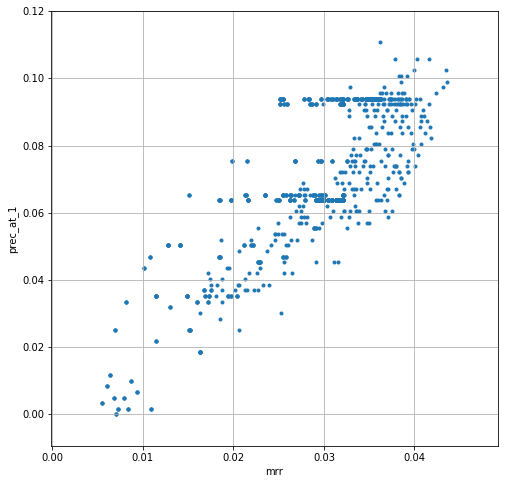

In [31]:
prec_type = 'prec_at_1'
plt.figure(figsize=(8,8))
plt.scatter(results_df['mrr'], results_df[prec_type], marker='.')
plt.xlabel('mrr')
plt.ylabel(prec_type)
plt.grid(True)

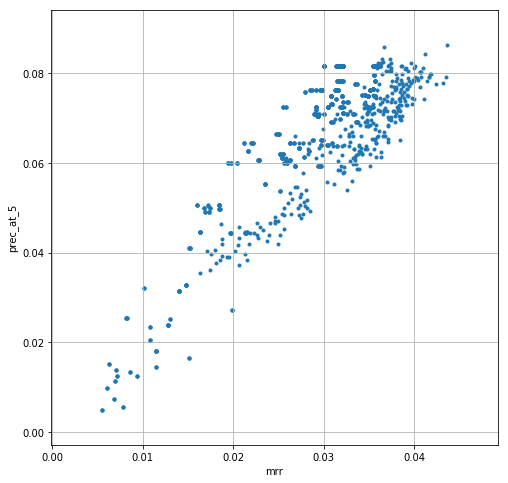

In [32]:
prec_type = 'prec_at_5'
plt.figure(figsize=(8,8))
plt.scatter(results_df['mrr'], results_df[prec_type], marker='.')
plt.xlabel('mrr')
plt.ylabel(prec_type)
plt.grid(True)

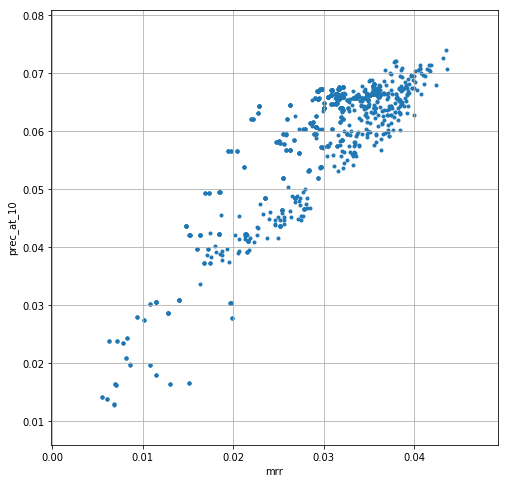

In [33]:
prec_type = 'prec_at_10'
plt.figure(figsize=(8,8))
plt.scatter(results_df['mrr'], results_df[prec_type], marker='.')
plt.xlabel('mrr')
plt.ylabel(prec_type)
plt.grid(True)

**Best BilinearNet Matrix Factorization Configuration (optimizing for MRR)**

In [13]:
results_df = pd.read_csv('20190414_mf_hyperopt.csv')

In [14]:
results_df.sort_values('mrr', ascending=False).iloc[0]

torch_init_seed    147.000000
learning_rate        0.003000
l2                   0.000000
epoch               14.000000
mrr                  0.043602
prec_at_1            0.098993
prec_at_5            0.086242
prec_at_10           0.070638
Name: 414, dtype: float64

In [15]:
best_config = config['mf_best_params']

In [16]:
mf_model = BilinearNet(train_data.n_users, test_data.n_items,
                       embedding_dim=config['embedding_dim'],
                       torch_seed=int(best_config['torch_init_seed']))

In [17]:
mf_est = ImplicitEst(model=mf_model,
                     n_iter=int(best_config['n_epochs']),
                     use_cuda=is_cuda_available(),
                     random_state=np.random.RandomState(
                         seed=config['estimator_init_seed']),
                     l2=best_config['l2'],
                     learning_rate=best_config['learning_rate'])

In [18]:
mf_est.fit(train_data, verbose=True)

Epoch 0: loss 0.43861536060408324
Epoch 1: loss 0.1956745327040336
Epoch 2: loss 0.13790130109116217
Epoch 3: loss 0.11952969229864309
Epoch 4: loss 0.10587907385396018
Epoch 5: loss 0.09613567403905941
Epoch 6: loss 0.08570984015702854
Epoch 7: loss 0.08138952391770594
Epoch 8: loss 0.07480364876090612
Epoch 9: loss 0.06803838513878448
Epoch 10: loss 0.0646558161648452
Epoch 11: loss 0.061534061768627114
Epoch 12: loss 0.05561618223031521
Epoch 13: loss 0.05531438983469094
Epoch 14: loss 0.05186383812294583


In [19]:
mf_mrr = mrr_score(mf_est, test_data).mean()

In [20]:
mf_mrr

0.043602230491801765

In [21]:
best_config['mrr']

0.043602

In [22]:
np.testing.assert_almost_equal(mf_mrr, best_config['mrr'], decimal=4)

In [24]:
mf_auc = auc_score(mf_est, test_data, config['auc_selection_seed']).mean()

In [25]:
mf_auc

0.9210500681671108

In [26]:
mf_map = precision_recall_score(mf_est, test_data, k=10)[0].mean()

In [27]:
mf_map

0.07063758389261744